#Import Libraries

In [24]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import requests
import pandas as pd
import csv
import numpy as np
import time
import tensorflow as tf
import scipy
import math
import requests
import time
import datetime
from scipy import stats

#Preprocess Data

Dataframe Shape: (1123764,)


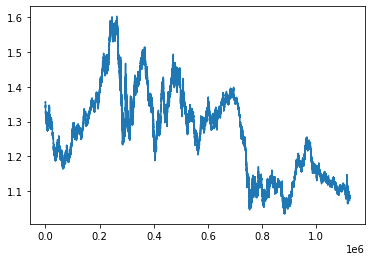

In [28]:
df = pd.read_csv('/content/EURUSD_MN.csv') #Download EURUSD Minute data in CSV format

df = np.array(df['BO'][::5], dtype=np.float32) #Index through the data by intervals of 5 to get 5 minute data
print('Dataframe Shape: ' + str(df.shape))

plt.plot(df)
plt.show()

In [29]:
def calc_macd_and_ema(X, display=False):
  '''Calculates the Moving Average Convergence Divergence Indicator
     and the Exponential Moving Average Indicator'''
  macd, ema = [-.1], [1.]

  for i in range(1, len(X)):
    e26 = X[i] * (2 / 27) + X[i-1] * (1 - (2 / 27))
    e12 = X[i] * (2 / 27) + X[i-1] * (1 - (2 / 13))
    m = e12 - e26

    ema.append(e12)
    macd.append(m)

  if display:
    plt.plot(macd)
    plt.title('MACD')
    plt.show()

    plt.plot(ema)
    plt.title('EMA')
    plt.show()

  return np.array(macd), np.array(ema)


def calc_sma(X, window, display=False):
  '''Calculates the Simple Moving Average Indicator'''
  sma = [1.]
  for i in range(1, len(X)):
    if i < window:
      sma.append((sum(X[:i])) / i)
    else: 
      sma.append((sum(X[i-window:i])) / window)

  if display:
    plt.plot(sma)
    plt.title('SMA')
    plt.show()  

  return np.array(sma)

def calc_rsi(X, display=False):
  '''Calculates the Relative Strength Index'''
  look_back = 24
  rsi = np.zeros((len(X)), dtype=np.float32)
  rsi[0] = 50.
  avu = [.001]
  avd = [.001]
  for i in range(1, len(X)):

    if X[i] > X[i-1]:
      avu.append(X[i]/X[i-1])
      if len(avu) > look_back: avu.pop(0)

    else:
      avd.append(X[i]/X[i-1])
      if len(avd) > look_back: avd.pop(0)
    r = (100 - (100 / (1 + (np.mean(avu) / np.mean(avd)))))
      
    if 50. < r < 50.1: rsi[i] = (r) 
    else: rsi[i] = 50.

  if display:
    plt.plot(rsi)
    plt.title('RSI')
    plt.show()

  return np.array(rsi)

def calc_BB(X, ma, display=False):
  '''Calculates the Bollinger Bands Indicator'''
  window = 48
  bbu, bbd = np.zeros((len(X)), dtype=np.float32), np.zeros((len(X)), dtype=np.float32)
  bbu[0] = 0.
  bbd[0] = 0.

  for i in range(1, len(X)):
    if i < window:
      bbu[i] = (ma[i] * np.mean(X[:window]) + 2 * np.std(X[:window]))
      bbd[i] = (ma[i] * np.mean(X[:window]) - 2 * np.std(X[:window]))
    else:
      bbu[i] = (ma[i] * np.mean(X[i-window:i]) + 2 * np.std(X[i-window:i]))
      bbd[i] = (ma[i] * np.mean(X[i-window:i]) - 2 * np.std(X[i-window:i]))

  if display:
    plt.plot(bbu[10000:])
    plt.plot(bbd[10000:])
    plt.title('BBands')
    plt.show()

  return np.array(bbu), np.array(bbd)


In [30]:
macd, ema = calc_macd_and_ema(df, display=False)
sma = calc_sma(df, window=32, display=False)
rsi = calc_rsi(df, display=False)
bbu, bbd = calc_BB(df, sma, display=False)

print(f'EMA Shape: {ema.shape}')
print(f'RSI Shape: {rsi.shape}')
print(f'MACD Shape: {macd.shape}')
print(f'SMA Shape: {sma.shape}')

EMA Shape: (1123764,)
RSI Shape: (1123764,)
MACD Shape: (1123764,)
SMA Shape: (1123764,)


In [31]:
def split_sequences(xs, ys, n_steps):
  '''
  Takes an input sequence and splits it into multiple windows
  Input array will be shape [examples, features, 1]
  Output array will be shape [examples, time steps, features, 1]
  '''
  X = np.zeros((xs.shape[0], n_steps, xs.shape[1], 1), dtype=np.float32)
  Y = np.zeros((ys.shape[0], n_steps, 1), dtype=np.float32)
  for i in range(len(xs)):
    end_ix = i + n_steps
    if end_ix == len(xs):
      break

    seq_x = xs[i:end_ix, :]
    seq_y = ys[i:end_ix]
    zeros = np.zeros((n_steps, 7, 1))

    if np.array_equal(seq_x, zeros):
      break
    X[i] = seq_x
    Y[i] = seq_y

  #print(f'Split X Shape: {np.array(X).shape}')
  #print(f'Split Y Shape: {np.array(Y).shape}')
  return np.array(X, dtype=np.float64), np.array(Y, dtype=np.float64)

In [39]:
#Reshape data
macd = macd.reshape(df.shape[0], 1)
sma = sma.reshape(df.shape[0], 1)
ema = ema.reshape(df.shape[0], 1)
rsi = rsi.reshape(df.shape[0], 1)
bbu = bbu.reshape(df.shape[0], 1)
bbd = bbd.reshape(df.shape[0], 1)
price = df.reshape(df.shape[0], 1)
bin = np.zeros((df.shape[0], 1))

#Normalize the data
macd = scipy.stats.zscore(macd)
sma =  scipy.stats.zscore(sma)
ema = scipy.stats.zscore(ema)
rsi =  scipy.stats.zscore(rsi)

#Create Binary Labels
for i in range(df.shape[0]-1):
  if price[i+1] > price[i]:
    bin[i] = 1
  elif price[i+1] < price[i]:
    bin[i] = 0
  else: bin[i] = 1
  if i == df.shape[0]:
    bin[i] = 1

test_range = price.shape[0] - 100000
val_range = price.shape[0] - 50000

data = np.stack((macd,sma,ema,rsi,bbu,bbd,price), axis=1) #Stack Data
train = data[:test_range,...]
test = data[test_range:val_range,...]
val = data[val_range:,...]

#Inputs
X_train, _ = split_sequences(train, bin[:test_range], 32)
Y_train = bin[:test_range]
X_test, _ = split_sequences(test, bin[test_range:val_range], 32)
Y_test = bin[test_range:val_range]
X_val, _ = split_sequences(val, bin[val_range:], 32)
Y_val = bin[val_range:]

print(f'X Train Shape: {X_train.shape}')
print(f'X Test Shape: {X_test.shape}')
print(f'Y Train Shape: {Y_train.shape}')
print(f'Y Test Shape: {Y_test.shape}')


X Train Shape: (1023764, 32, 7, 1)
X Test Shape: (50000, 32, 7, 1)
Y Train Shape: (1023764, 1)
Y Test Shape: (50000, 1)


#Establish Metrics, Callbacks, and Simulation

In [67]:
#Callback

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('loss')<0.001):
            print("\nReached 0.001 Loss so cancelling training!")
            self.model.stop_training = True
callback = myCallback()

In [68]:
#CNN Simulation
def cnn_simulation(bank, model, volatility, period,  metrics = []):
  initial = bank
  banked_shares = 100
  savings = 0
  def buy(bank, current_price, banked_shares):
    available_shares = math.floor(bank / current_price)
    bought = math.floor(available_shares * volatility)
    banked_shares += bought
    bank -= (bought * current_price)

    #print(f'BOUGHT: {bought} shares, bank: {bank}, current price: {current_price}') # USE FOR DEBUGGING
    
    return banked_shares, bank

  def sell(bank, current_price, banked_shares, savings):
    liquidity = math.floor(banked_shares * current_price * volatility)
    sold = math.floor(banked_shares * volatility)
    if banked_shares > sold:
      bank += liquidity
      banked_shares -= sold
    #if bank > (initial * 1.5):
    #  saved = (bank - (initial * 1.5))
    #  savings += saved
    #  bank -= saved

    #print(f'SOLD: {sold} shares, bank: {bank}, current price: {current_price}, savings: {savings}') # USE FOR DEBUGGING
    
    return banked_shares, bank, savings
  
  pred = model.predict(X_TE_C)
  print(pred.shape)

  trades = 0
  for i in range(period):
  
    if (np.round(pred[i]) == 1):
      trades += 1
      banked_shares, bank = buy(bank, price_test[i], banked_shares)
      metrics.append(bank)
      #print(f'Trade # {trades}: BOUGHT     banked_shares: {banked_shares}       bank: {bank}')
    elif (np.round(pred[i]) == 0) and (banked_shares > 1):
      trades += 1
      banked_shares, bank, savings = sell(bank, price_test[i], banked_shares, savings)
      metrics.append(bank)
      #print(f'Trade # {trades}: SOLD     banked_shares: {banked_shares}       bank: {bank}')

    elif i == 50000:
      bank += (banked_shares * price_test[i])
    else:
      pass 
  print('Bank: ', bank, ' ````` Mean: ', np.mean(metrics), '````` Savings: ', savings)
  return metrics

#Convolutional Model

In [69]:
def last_time_step_mse(Y_true, Y_pred):
  return tf.keras.metrics.mean_squared_error(Y_true[:-1], Y_pred[:-1])

def run_conv(X, Y):
  model = tf.keras.models.Sequential([
          tf.keras.layers.Conv2D(128, kernel_size=(7,16), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
          tf.keras.layers.MaxPool2D((2,2)),
          tf.keras.layers.Conv2D(32, kernel_size=(7,4), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
          tf.keras.layers.MaxPool2D((2,2)),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001,), loss='binary_crossentropy', metrics=['accuracy'])
  history = model.fit(X,Y, validation_data = (X_val, Y_val), epochs=128, batch_size=32, callbacks=[callback])
  return history, model

In [ ]:
history, model = run_conv(X_train, Y_train)

Epoch 1/128
7999/7999 [==============================] - 41s 5ms/step - loss: 0.6968 - accuracy: 0.5140 - val_loss: 0.6939 - val_accuracy: 0.5155
Epoch 2/128
7999/7999 [==============================] - 39s 5ms/step - loss: 0.6946 - accuracy: 0.5154 - val_loss: 0.6920 - val_accuracy: 0.5318
Epoch 3/128
7999/7999 [==============================] - 40s 5ms/step - loss: 0.5343 - accuracy: 0.7467 - val_loss: 0.3845 - val_accuracy: 0.8541
Epoch 4/128
7999/7999 [==============================] - 39s 5ms/step - loss: 0.2776 - accuracy: 0.9463 - val_loss: 0.4179 - val_accuracy: 0.8109
Epoch 5/128
7999/7999 [==============================] - 40s 5ms/step - loss: 0.2558 - accuracy: 0.9516 - val_loss: 0.3456 - val_accuracy: 0.8814
Epoch 6/128
7999/7999 [==============================] - 40s 5ms/step - loss: 0.2408 - accuracy: 0.9552 - val_loss: 0.2861 - val_accuracy: 0.9642
Epoch 7/128
7999/7999 [==============================] - 39s 5ms/step - loss: 0.2296 - accuracy: 0.9576 - val_loss: 0.3162 -

In [ ]:
#Evaluate the model on test set
model.evaluate(X_test, Y_test)

#Plot predictions vs true values
pred = model.predict(X_test)
plt.figure(figsize=(15,10))
plt.plot(pred[:50], 'b', label='Pred')
plt.plot(Y_test[:50], 'r', label='YS')
plt.show()

#Plot model loss and accuracy
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['accuracy'], label='Accuracy')
plt.title('Loss and Accuracy')
plt.show()

#Plot model validation loss and accuracy
plt.plot(history.history['val_loss'], label=' Val Loss')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Val Loss and Accuracy')
plt.show()

In [ ]:
model.save('FX_Model.h5')